# Introduction to VoxelMorph
[Adrian Dalca](http://adalca.mit.edu) and Andrew Hoopes    
Introductory slides for this tutorial are [here](https://github.com/learn2reg/tutorials2019/blob/master/slides/Learn2reg_tutorial_unsupervided_AdrianDalca.pdf). 

This is a short tutorial to get you started with [VoxelMorph](https://github.com/voxelmorph/voxelmorph): deep-learning based registration.

### Outline
- **Core concepts with MNIST**   
We will first learn to deal with data, building a model, training, registration and generalization
- **More realistic complexity: Brain MRI (2D slices)**  
We will then show how these models work for 2d slices of brain scans, presenting a more complex scenario    
- **Realistic 3D Brain MRI**  
We will illustrate full 3D registration
- **Advances topics**  
Finally, we close with more advanced topics, including diffeomorphisms and fine-tuning deformations

---

We'll start with some common imports  

In [1]:
# imports
import os, sys

# voxel morph imports
import tensorflow as tf
import voxelmorph as vxm
import neurite as ne
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

import numpy as np
import scipy.ndimage as ndi
import h5py
import cv2

#plotting
import matplotlib.pyplot as plt

# Registration of Brain MRI

In [2]:
hf = h5py.File("dataset2.h5", "r")

In [3]:
nb_entries = len(hf.keys())
list_keys = list(hf.keys())
keys_random = np.random.permutation(list_keys)

keys_train = keys_random[:int(nb_entries*0.8)]
keys_test  = keys_random[int(nb_entries*0.8):]

treated_slice = 21

In [4]:
n = hf.get("1")
slice_ = 18
img_0 = np.array(n["frame"])[0][:,:,slice_]
img_1 = np.array(n["frame"])[1][:,:,slice_]
img_d = np.zeros(n["frame"][1][:,:,slice_].shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


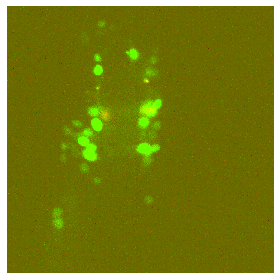

In [5]:
# RGB - Blue
zipped = np.dstack((img_0/255, img_1/255, img_d/255))
ne.plot.slices(zipped, do_colorbars=True, width=4);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


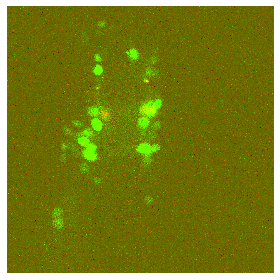

In [6]:
#sharpening
mask = np.array([[-2, -2, -2],
                 [-2, 32, -2],
                 [-2, -2, -2]])

img_0_s = ndi.convolve(img_0, mask, output=np.int16)
img_1_s = ndi.convolve(img_1, mask, output=np.int16)
img_d_s = ndi.convolve(img_d, mask, output=np.int16)

norm = 255*16
zipped = np.dstack((img_0_s/norm, img_1_s/norm, img_d_s/norm))
ne.plot.slices(zipped, do_colorbars=True, width=4);

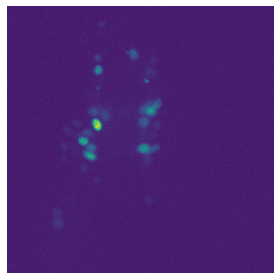

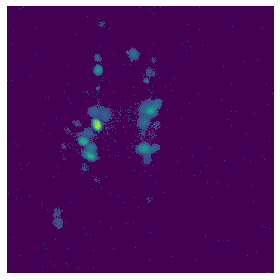

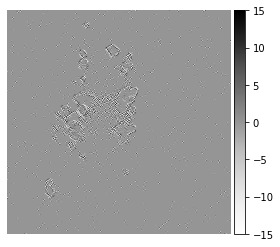

In [8]:
#edge detection
mask = np.array([[1, 0, -1],
                 [2, 0, -2],
                 [1, 0, -1]])

img_grey = img_0 + img_1 + img_d
img_grey = img_grey / 255

ne.plot.slices(img_grey, do_colorbars=True, width=4);

img_grey_ths = img_grey
img_grey_ths[np.where(img_grey_ths < 1)] = 0

ne.plot.slices(img_grey_ths, do_colorbars=True, width=4);

img_grey_x = ndi.convolve(img_grey_ths, mask, output=np.int16)

img_grey_y = ndi.convolve(img_grey_x, mask.T, output=np.int16)

ne.plot.slices(img_grey_y, cmaps=["Greys"], do_colorbars=True, width=4);

In [9]:
def nothing(x):
    pass
cv2.namedWindow('canny')
switch = '0 : OFF \n1 : ON'
cv2.createTrackbar(switch, 'canny', 0, 1, nothing)
cv2.createTrackbar('lower', 'canny', 0, 255, nothing)
cv2.createTrackbar('upper', 'canny', 0, 255, nothing)
img_0_c = np.uint8(img_0)
res = cv2.resize(img_0_c,(500,500))

while(1):
    lower = cv2.getTrackbarPos('lower', 'canny')
    upper = cv2.getTrackbarPos('upper', 'canny')
    s = cv2.getTrackbarPos(switch, 'canny')
    
    if s == 0:
        edges = res
    else:
        edges = cv2.Canny(res,lower,upper)
    cv2.imshow('canny',edges)
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break
cv2.destroyAllWindows()

In [ ]:
img_0

In [ ]:
img_0_c = np.uint8(img_0)
ne.plot.slices(cv2.Canny(img_0_c,10,200), cmaps=["Greys"], do_colorbars=True, width=4);


In [ ]:
#load the training set + normalization
slices_train = np.zeros((len(keys_train),112,112))
for i, key in enumerate(keys_train):
    slices_train[i] = np.array(hf.get(key)["frame"][0][:,:,21])/255

In [ ]:
#load the training set + normalization
slices_test = np.zeros((len(keys_test),112,112))
for i, key in enumerate(keys_test):
    slices_test[i] = np.array(hf.get(key)["frame"][0][:,:,21])/255
    
vol_shape = slices_train.shape[1:]

In [ ]:
# extract some brains
nb_vis = 5
idx = np.random.randint(0, slices_train.shape[0], [5,])
example_digits = [f for f in slices_train[idx, ...]]

# visualize
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

### Model

As with MNIST, let's create a standard VoxelMorph model trained with MSE and spatial smoothing losses.

In [ ]:
def vxm_data_generator(x_data, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

In [ ]:
# configure unet input shape (concatenation of moving and fixed images)

# configure unet features 
nb_features = [
    [32, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16]  # decoder features
]

# build model using VxmDense
inshape = slices_train.shape[1:]
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

# voxelmorph has a variety of custom loss classes
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter
lambda_param = 0.05
loss_weights = [1, lambda_param]

vxm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)

In [ ]:
a = vxm_data_generator(slices_train, batch_size=8)

In [ ]:
b = next(a)

In [ ]:
b[0][0].sum()

In [ ]:
# let's test it
train_generator = vxm_data_generator(slices_train, batch_size=8)
in_sample, out_sample = next(train_generator)

# visualize
images = [img[0, :, :, 0] for img in in_sample + out_sample]
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

Looks good, time to **train the model**

In [ ]:
hist = vxm_model.fit_generator(train_generator, epochs=10, steps_per_epoch=100, verbose=1);

In [ ]:
import matplotlib.pyplot as plt

def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

In [ ]:
# as before, let's visualize what happened
plot_history(hist)

In [ ]:
# create the validation data generator
val_generator = vxm_data_generator(slices_test, batch_size = 1)

In [ ]:
val_input, _ = next(val_generator)

In [ ]:
# prediction
val_pred = vxm_model.predict(val_input)

In [ ]:
val_input, _ = next(val_generator)

# prediction
val_pred = vxm_model.predict(val_input)

# visualize registration
images = [img[0, :, :, 0] for img in val_input + val_pred] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [ ]:
# visualize flow
flow = val_pred[1].squeeze()[::3,::3]
ne.plot.flow([flow], width=5);

In [ ]:
vxm_model.save_weights("weights.keras")

# Evaluation

Evaluating registration results is tricky. The first tendancy is to look at the images (as above), and conclude that if they match, The registration has succeeded.

However, this can be achieved by an optimization that only penalizes the image matching term. For example, next we compare our model with one that was trained on maximizing MSE only (without smoothness loss).

In [ ]:
# prediction from model with MSE + smoothness loss
vxm_model.load_weights('weights.keras')
our_val_pred = vxm_model.predict(val_input)

# prediction from model with just MSE loss
# vxm_model.load_weights('brain_2d_no_smooth.h5')
# mse_val_pred = vxm_model.predict(val_input)

In [ ]:
# visualize MSE + smoothness model output
images = [img[0, ..., 0] for img in [val_input[1], *our_val_pred]]
titles = ['fixed', 'MSE + smoothness', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

# visualize MSE model output
#images = [img[0, ..., 0] for img in [val_input[1], *mse_val_pred]]
#titles = ['fixed', 'MSE only', 'flow']
#ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

# 3D MRI brain scan registration

Finally, we get to 3D models, which are of particular interest in medical image analysis.

However, due to the size of the models and data, we won't be able to train a model within a short tutorial time. Instead, here we assume one has been trained, and demonstrate its use. You can train one very similar to how you trained the 2D models above.

### Model

In [ ]:
# our data will be of shape 112 x 112 x 32
vol_shape = (112, 112, 32)
nb_features = [
    [16, 32, 32, 32],
    [32, 32, 32, 32, 32, 16, 16]
]

In [ ]:
# build vxm network
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0);

### Validation data

Let's prepare our validation data.

In [ ]:
val_volume_1 = np.load('subj1.npz')['vol']
seg_volume_1 = np.load('subj1.npz')['seg']
val_volume_2 = np.load('subj2.npz')['vol']
seg_volume_2 = np.load('subj2.npz')['seg']

val_input = [
    val_volume_1[np.newaxis, ..., np.newaxis],
    val_volume_2[np.newaxis, ..., np.newaxis]
]

In [ ]:
#load the training set + normalization
slices_train_3d = np.zeros((len(keys_train),112,112,32))
for i, key in enumerate(keys_train):
    slices_train_3d[i] = np.array(hf.get(key)["frame"][0][:,:,:])/255

In [ ]:
#load the training set + normalization
slices_test_3d = np.zeros((len(keys_test),112,112,32))
for i, key in enumerate(keys_test):
    slices_test_3d[i] = np.array(hf.get(key)["frame"][0][:,:,:])/255

In [ ]:
val_input = [x[np.newaxis, ..., np.newaxis] for x in slices_train_3d]

In [ ]:
val_input[0].shape

In [ ]:
# voxelmorph has a variety of custom loss classes
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter
lambda_param = 0.05
loss_weights = [1, lambda_param]

In [ ]:


vxm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)

train_generator = vxm_data_generator(slices_train_3d, batch_size=8)

hist = vxm_model.fit(train_generator, epochs=5, steps_per_epoch=10, verbose=1);

Now let's register.

In [ ]:
val_pred = vxm_model.predict(val_input);

In [ ]:
moved_pred = val_pred[0].squeeze()
pred_warp = val_pred[1]

In [ ]:
mid_slices_fixed = [np.take(val_volume_2, vol_shape[d]//2, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_pred = [np.take(moved_pred, vol_shape[d]//2, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[2,3]);

Let's look at the segmentations! To do this, we'll need to warp segmentations. 

In [ ]:
warp_model = vxm.networks.Transform(vol_shape, interp_method='nearest')

## Runtime

An important advantage of learning-based methods is the dramatically lowered runtime.

In [ ]:
%timeit vxm_model.predict(val_input)

In our tests, a run is 10s, for an entire 3D volume. Classically, this would take hours.